<a href="https://colab.research.google.com/github/Itai1991Ortner/Google-Play/blob/main/Google_play_Itai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from datetime import datetime
import regex as re
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from datetime import datetime
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
my_path ='/content/drive/My Drive/My Regression Task /Google-Playstore.csv'
df=pd.read_csv(my_path)

# Date cleaning

In [4]:
#first cleaning
df=df.rename(lambda col: col.lower(),axis=1).rename(lambda col: col.strip(),axis=1)
df.columns = df.columns.str.replace(' ','_')
df=df.drop(columns=["minimum_android","currency","price","free","installs","app_name","app_id","developer_website","developer_email","privacy_policy","released","developer_id"],axis=1)
df["category"]=df["category"].fillna('Casual')
df=df[df["size"].str[-1]!='e']
df=df.dropna(subset=["rating"])
df=df[df["rating"]>0.0]
df["content_rating"]=df["content_rating"].replace({'Mature 17+':'Adults only 18+'})

In [5]:
#converting to uniform size
def fix_size(df):
  df["mekadem"]=df['size'].str[-1]
  df["number"]=df["size"].str[:-1]
  df["mekadem"]=df["mekadem"].replace({'M': 1.0, 'k' : 0.001, 'G': 1000.0})
  df["size"]=df["mekadem"]*df["number"].str.replace(',','').astype(float)
  df=df.drop(columns=["number","mekadem"],axis=1)

  return df

In [6]:
#converting to uniform size
def mean_install(df):
  df["minimum_installs"]=df["minimum_installs"].fillna(df["minimum_installs"].mean())
  df["installs"]=(df["maximum_installs"]+df["minimum_installs"])/2
  df=df.drop(columns=["maximum_installs","minimum_installs"],axis=1)

  return df

In [7]:
#converting dates to days
def days_delta(date):
  date = datetime.strptime(date,"%b %d, %Y")

  td= (datetime(2020,12,1) - date)
  num_days=td / timedelta (days=1)

  return num_days

In [8]:
#converting to uniform size>> for minimum android feature add to  X model
def min_android(str_android):
  new_str=re.sub('[^0-9\.\0-9]+','',str_android)
  if '-' in new_str:
    new_str=new_str.split('-')[0]

  return new_str

In [9]:
#-->fullfilling the methods
df=df.pipe(fix_size)
df=df.pipe(mean_install)
df["last_updated"]=df["last_updated"].apply(lambda d: days_delta(d))

# Visualization

In [10]:
#summry table
def table_info(df):
    print(f"Dataset Shape: {df.shape}")
    first_check = pd.DataFrame(df.dtypes,columns=['dtypes'])
    first_check = first_check.reset_index()
    first_check['Name'] = first_check['index']
    first_check = first_check[['Name','dtypes']]
    first_check['isnull'] = df.isnull().sum().values    
    first_check['nUniques'] = df.nunique().values

    return first_check

In [11]:
table_info(df)

Dataset Shape: (652572, 10)


,Name,dtypes,isnull,nUniques
0,category,object,0,48
1,rating,float64,0,41
2,rating_count,float64,0,31925
3,size,float64,0,1459
4,last_updated,float64,0,3664
5,content_rating,object,0,5
6,ad_supported,bool,0,2
7,in_app_purchases,bool,0,2
8,editors_choice,bool,0,2
9,installs,float64,0,196482


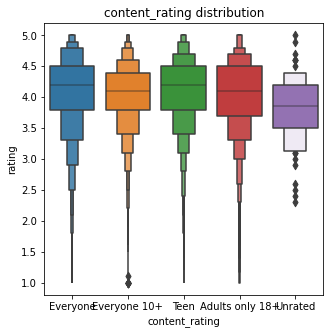

In [12]:
plt.figure(figsize=(5,5))
sns.boxenplot(x='content_rating',y='rating',data=df)
plt.title('content_rating distribution')
plt.show()

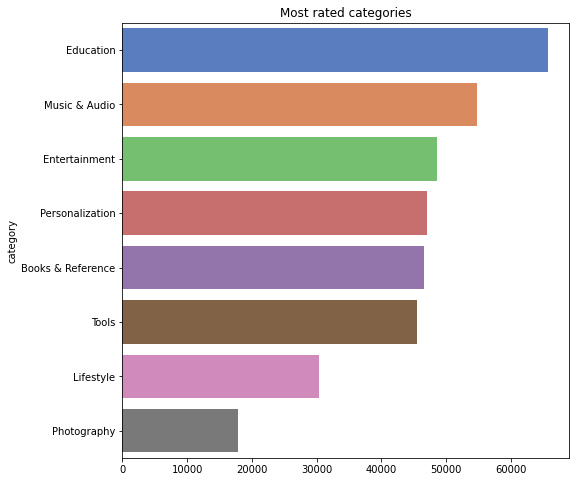

In [13]:
cat_to_insatlls=df.groupby("category")["rating"].size().sort_values(ascending=False).head(8)
plt.subplots(figsize= (8,8))
sns.barplot(y=cat_to_insatlls.index,x=cat_to_insatlls.values,palette='muted')
plt.title("Most rated categories")
plt.show()

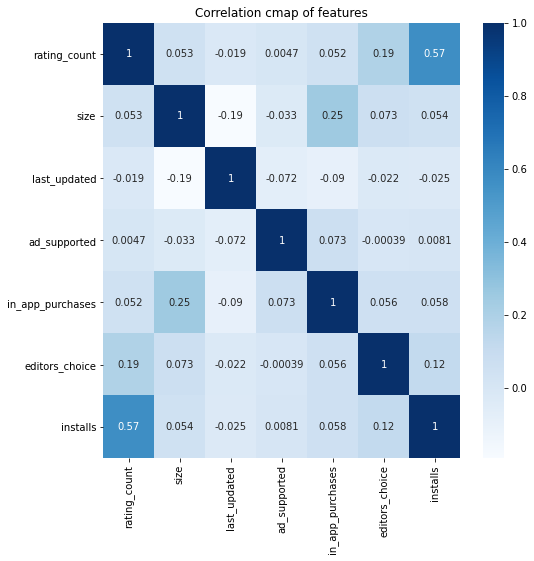

In [103]:
#correlation heatmap plot
plt.figure(figsize=(8,8))
correl=df.drop(['rating'],axis=1).corr()
sns.heatmap(correl,annot=True,cmap='Blues')
plt.title('Correlation cmap of features')
plt.show()

In [15]:
#correlatin function method
def correlation(df,threshold):
  col_corr=set()
  corr_matrix=df.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range (i):
      if abs(corr_matrix.iloc[i,j])>threshold:
        col_name=corr_matrix.columns[i]
        col_corr.add(col_name)

  return col_corr

In [16]:
corr_features=correlation(df.drop(["rating"],axis=1),0.1)
print(f"The of most correlated featrues are  {corr_features}")

The of most correlated featrues are  {'editors_choice', 'in_app_purchases', 'installs', 'last_updated'}


Text(0.5, 1.0, 'Target distribution')

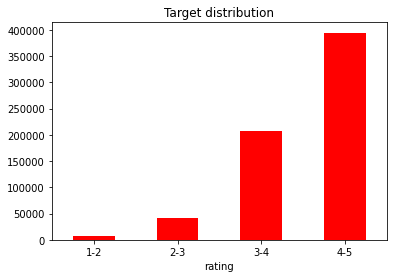

In [127]:
x_labels_name=['1-2','2-3','3-4','4-5']
df_rating = df.groupby(pd.cut(df['rating'], bins=[1,2,3,4,5])).size()
df_rating.plot.bar(color='red')
plt.xticks([0,1,2,3],x_labels_name,rotation=0)
plt.title('Target distribution')

#Preprocessing

In [32]:
#initiating X and y
X=df.drop(columns=["rating"])
y=df["rating"]

In [33]:
#spliting the Data
X_train,X_test,y_train,y_test=split(X,y, test_size=0.3,random_state=1)

In [41]:
#one_hot_encoder transformer
class MyOneHotEncoder(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    
    def fit(self, X, y=None):
        self.ohe.fit(X[["category","content_rating","ad_supported","in_app_purchases","editors_choice"]])
        return self
    
    def transform(self, X):
        transformed_data = pd.DataFrame(self.ohe.transform(X[["category","content_rating","ad_supported","in_app_purchases","editors_choice"]]))
        numerical_features = X.drop(columns=["category","content_rating","ad_supported","in_app_purchases","editors_choice"], axis=1)
        
        return np.concatenate([numerical_features,transformed_data], axis=1)
    def get_feature_names(self):
        pass

In [42]:
#initiate the OHE transformer
my_ohe=MyOneHotEncoder()
X_train_ohe=my_ohe.fit_transform(X_train)
X_test_ohe=my_ohe.transform(X_test)

# Model

# XGBoost

In [49]:
x_boost=xgb.XGBRegressor()

xgb_params={
'learning_rate':[0.05,0.1,0.15,0.2,0.25,0.5],
'n_jobs':[-1],
'max_depth':[2,3,5,7,10],
'n_estimators': [10,50,100,200,300],
'gamma':[0.0,0.1,0.2,0.5],
'scale_pos_weight': [1,3,5]        
        }

xgb_random_search=RandomizedSearchCV(x_boost,xgb_params,n_iter=10,scoring='neg_mean_absolute_error',cv=5,verbose=2)

In [ ]:
xgb_random_search.fit(X_train_ohe,y_train)

In [51]:
xgb_random_search.best_params_

{'gamma': 0.2,
 'learning_rate': 0.5,
 'max_depth': 5,
 'n_estimators': 100,
 'n_jobs': -1,
 'scale_pos_weight': 5}

In [52]:
y_pred=xgb_random_search.predict(X_test_ohe)

In [53]:
mean_absolute_error(y_test, y_pred)

0.4276066634167766

# Random Forest

In [44]:
r_forest=RandomForestRegressor()

forest_params={
'n_jobs':[-1],
'max_depth':[2,3,5,7,10],
'n_estimators': [50,100,200,300],
'min_samples_split': [3,5,10,30]        
        }

rnf_random_search=RandomizedSearchCV(r_forest,forest_params,n_iter=10,scoring='neg_mean_absolute_error',cv=5,verbose=2)

In [ ]:
rnf_random_search.fit(X_train_ohe,y_train)

In [46]:
rnf_random_search.best_params_

{'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}

In [47]:
y_pred=rnf_random_search.predict(X_test_ohe)

In [48]:
mean_absolute_error(y_test, y_pred)

0.45663961573081596

**Finally the better model is XGBoost which brings us the better results for this data**